# NOAA Fisheries Steller Sea Lion Population Count

## Image Preprocessing
There needs to be preprocessing to reduce the size of images to fit into memory. This notebook assumes the images are all resized to 512x512. This can be done using ImageMagik
```sh
mogrify -resize 512x512! -format png -path test_images_512x512 Test/*.jpg
```

In [35]:
import keras
import cv2
import sys
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D, Input, concatenate, GlobalMaxPooling2D
from keras.models import Model
from keras import backend as K
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.optimizers import SGD

%matplotlib notebook

## Configuration

In [36]:
n_classes= 5            
batch_size= 20
epochs= 80                   
image_size= 512  
model_name= 'cnn' 

train_dir = '/media/bss/Ubuntu HDD/noaa-sealions/data_512/train/train'
validation_dir = '/media/bss/Ubuntu HDD/noaa-sealions/data_512/validation'
test_dir = '/media/bss/Ubuntu HDD/noaa-sealions/data_512/test'

ignore_list = pd.read_csv('../data/miss_class.txt')['train_id'].tolist()

# verify files
len(os.listdir(test_dir)), len(os.listdir(train_dir)), len(os.listdir(validation_dir))

(17745, 713, 178)

In [37]:
'''
Data loading function
'''
def load_data(dir_path):
    df = pd.read_csv('../data/train.csv')
    
    n_train_wValidation_images = 713
    n_train_images = 948
    
    image_list = []  
    y_list = []      

    #for i in range(0, n_train_wValidation_images):
    for idx, i in enumerate(os.listdir(train_dir)):
        name = i.replace('.png','')
        img_path = os.path.join(train_dir, str(i))
        img = cv2.imread(img_path)
        image_list.append(img)

        row = df.iloc[int(name)]

        y_row = np.zeros((5))
        y_row[0] = row['adult_males']
        y_row[1] = row['subadult_males']
        y_row[2] = row['adult_females']
        y_row[3] = row['juveniles']
        y_row[4] = row['pups']
        y_list.append(y_row)
    x_train = np.asarray(image_list)
    y_train = np.asanyarray(y_list)
    
    print('X Train: ' + str(x_train.shape) + '\nY Train: ' + str(y_train.shape))
    return x_train, y_train

In [38]:
'''
Load validation data
'''
def load_validation_data(dir_path):
    df = pd.read_csv('../data/train.csv')
    
    n_valid_images = 179  #948
    
    image_list = []
    y_list = []
    
    #for i in range(0, n_valid_images):
    for idx, i in enumerate(os.listdir(validation_dir)):
        name = i.replace('.png','')
        img_path = os.path.join(validation_dir, str(i)) # + '.png'
        img = cv2.imread(img_path)
        image_list.append(img)

        row = df.iloc[int(name)]

        y_row = np.zeros((5))
        y_row[0] = row['adult_males']
        y_row[1] = row['subadult_males']
        y_row[2] = row['adult_females']
        y_row[3] = row['juveniles']
        y_row[4] = row['pups']
        y_list.append(y_row)
    x_train = np.asarray(image_list)
    y_train = np.asanyarray(y_list)
    
    print('X Train: ' + str(x_train.shape) + '\nY Train: ' + str(y_train.shape))
    return x_train, y_train

## VGG16 Model

In [23]:
'''
'''
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(512, 512, 3))  #weights='imagenet'
conv_base_train = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(512, 512, 3))

In [28]:
model = Sequential()
model.add(conv_base)
#model.add(conv_base_train).layers[:15]
model.add(Conv2D(512, (3,3), activation='relu'))
model.add(Conv2D(n_classes, (1,1), activation='relu'))
model.add(GlobalAveragePooling2D())

#model.add(Conv2D(n_classes, kernel_size=(3, 3), padding='same'))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))

#model.add(GlobalAveragePooling2D())
'''
new test
'''
#model.add(Flatten())
#model.add(Dense(512))
#model.add(Dense(512, activation="relu"))
#model.add(Dense(5, activation='sigmoid'))
#model.add(Dropout(0.2))
#model.add(Dense(5))

#model.add(Activation('sigmoid'))
#model.add(Dense(5))

#sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=keras.losses.mean_squared_error, 
              optimizer=keras.optimizers.Adam(lr=0.01), metrics=['accuracy'])  # losses.mean_squared_error

print(model.summary())

#conv_base.trainable = False  # freeze weights = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    else:
        set_trainable = False
#conv_base_train.trainable = True
print('Number of trainable weights: ', len(model.trainable_weights))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 16, 16, 512)       14714688  
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 512)       2359808   
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 5)         2565      
_________________________________________________________________
global_average_pooling2d_5 ( (None, 5)                 0         
Total params: 17,077,061
Trainable params: 17,077,061
Non-trainable params: 0
_________________________________________________________________
None
Number of trainable weights:  30


In [29]:
def train_vgg16_freezeweights(model):
    batch_size = 16
    x_train, y_train = load_data(os.path.join(train_dir, 'train'))  # '../data_512/' -or- train_dir
    validation_tuple = load_validation_data(validation_dir)
        
    datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=80)
    
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), 
                        steps_per_epoch = len(x_train) / batch_size, epochs = epochs, validation_data=validation_tuple)  #, validation_data=validation_tuple
    
    model.save('./models/' + model_name + 'vgg16_tilereg_test.h5')
    
    return history

In [30]:
history = train_vgg16_freezeweights(model)

X Train: (713, 512, 512, 3)
Y Train: (713, 5)
X Train: (178, 512, 512, 3)
Y Train: (178, 5)
Epoch 1/80
45/44 [==============================] - 45s - loss: 64227.2418 - acc: 0.1153 - val_loss: 2818.3574 - val_acc: 0.1067
Epoch 2/80
45/44 [==============================] - 45s - loss: 2167.9413 - acc: 0.1042 - val_loss: 2818.3574 - val_acc: 0.1067
Epoch 3/80
45/44 [==============================] - 45s - loss: 2242.4896 - acc: 0.1063 - val_loss: 2818.3574 - val_acc: 0.1067
Epoch 4/80
45/44 [==============================] - 45s - loss: 2203.7184 - acc: 0.1052 - val_loss: 2818.3574 - val_acc: 0.1067
Epoch 5/80
45/44 [==============================] - 45s - loss: 2176.2149 - acc: 0.1052 - val_loss: 2818.3574 - val_acc: 0.1067
Epoch 6/80
45/44 [==============================] - 45s - loss: 2229.6550 - acc: 0.1042 - val_loss: 2818.3574 - val_acc: 0.1067
Epoch 7/80
45/44 [==============================] - 45s - loss: 2169.1526 - acc: 0.1052 - val_loss: 2818.3574 - val_acc: 0.1067
Epoch 8/80


45/44 [==============================] - 44s - loss: 2200.1155 - acc: 0.1052 - val_loss: 2818.3574 - val_acc: 0.1067
Epoch 64/80
45/44 [==============================] - 44s - loss: 2167.6938 - acc: 0.1074 - val_loss: 2818.3574 - val_acc: 0.1067
Epoch 65/80
45/44 [==============================] - 44s - loss: 2231.8683 - acc: 0.1052 - val_loss: 2818.3574 - val_acc: 0.1067
Epoch 66/80
45/44 [==============================] - 44s - loss: 2173.0197 - acc: 0.1052 - val_loss: 2818.3574 - val_acc: 0.1067
Epoch 67/80
45/44 [==============================] - 44s - loss: 2213.6467 - acc: 0.1042 - val_loss: 2818.3574 - val_acc: 0.1067
Epoch 68/80
45/44 [==============================] - 44s - loss: 2179.6460 - acc: 0.1042 - val_loss: 2818.3574 - val_acc: 0.1067
Epoch 69/80
45/44 [==============================] - 44s - loss: 2175.4490 - acc: 0.1052 - val_loss: 2818.3574 - val_acc: 0.1067
Epoch 70/80
45/44 [==============================] - 44s - loss: 2166.0327 - acc: 0.1052 - val_loss: 2818.357

## Model

In [ ]:
'''
Original model w/ dropout layers
try sigmoid
'''
def get_dropout_model():
    input_shape = (image_size, image_size, 3)
    
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size = (3, 3), padding = 'same', input_shape = input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Conv2D(64, kernel_size = (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.2))
    
    model.add(Conv2D(128, kernel_size = (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    #model.add(Dropout(0.2))
    
    model.add(Conv2D(n_classes, kernel_size=(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.2))
    
    model.add(GlobalAveragePooling2D())
    #model.add(GlobalMaxPooling2D())
    
    print(model.summary())
    
    model.compile(loss = keras.losses.mean_squared_error,
                  metrics = ['accuracy'],
                  optimizer = keras.optimizers.Adadelta())  #keras.optimizers.Adam()
    return model

## Training

In [62]:
def train():
    model = test_model() #get_dropout_model() #get_vgg16_model()
    
    x_train, y_train = load_data('../data_512/')  #'../data_512/' train_dir
    validation_tuple = load_validation_data(validation_dir)
        
    datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, 
                                 rotation_range=80)
    
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), 
                        steps_per_epoch = len(x_train) / batch_size, 
                                  epochs = epochs, validation_data=validation_tuple)  #, validation_data=validation_tuple
    
    model.save('./models/' +'randomTest.h5')
    
    return history

In [63]:
history = train()

/home/bss/opt/anaconda3/envs/noaa/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", name="conv1_1")`
  if __name__ == '__main__':
/home/bss/opt/anaconda3/envs/noaa/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", name="conv1_2")`
  # This is added back by InteractiveShellApp.init_path()
/home/bss/opt/anaconda3/envs/noaa/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv2_1")`
  from ipykernel import kernelapp as app
/home/bss/opt/anaconda3/envs/noaa/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv2_2")`
/home/bss/opt/anaconda3/envs/noaa/lib/python3.6/site-packages

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_66 (ZeroPaddi (None, 514, 514, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 512, 512, 32)      896       
_________________________________________________________________
zero_padding2d_67 (ZeroPaddi (None, 514, 514, 32)      0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 512, 512, 32)      9248      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 256, 256, 32)      0         
_________________________________________________________________
zero_padding2d_68 (ZeroPaddi (None, 258, 258, 32)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 256, 256, 64)      18496     
__________

36/35 [==============================] - 22s - loss: 2162.1558 - acc: 0.3975 - val_loss: 2800.7777 - val_acc: 0.4775
Epoch 25/80
36/35 [==============================] - 21s - loss: 2168.1205 - acc: 0.4037 - val_loss: 2800.7777 - val_acc: 0.4775
Epoch 26/80
36/35 [==============================] - 22s - loss: 2268.6646 - acc: 0.3954 - val_loss: 2800.7777 - val_acc: 0.4775
Epoch 27/80
36/35 [==============================] - 22s - loss: 2154.8450 - acc: 0.4155 - val_loss: 2800.7777 - val_acc: 0.4775
Epoch 28/80
36/35 [==============================] - 22s - loss: 2157.5056 - acc: 0.3843 - val_loss: 2800.7777 - val_acc: 0.4775
Epoch 29/80
36/35 [==============================] - 22s - loss: 2159.1331 - acc: 0.4058 - val_loss: 2800.7777 - val_acc: 0.4775
Epoch 30/80
36/35 [==============================] - 22s - loss: 2172.1681 - acc: 0.4045 - val_loss: 2800.7777 - val_acc: 0.4775
Epoch 31/80
36/35 [==============================] - 22s - loss: 2160.3919 - acc: 0.3808 - val_loss: 2800.777

## Evaluation

In [ ]:
print(history.history.keys())

<IPython.core.display.Javascript object>


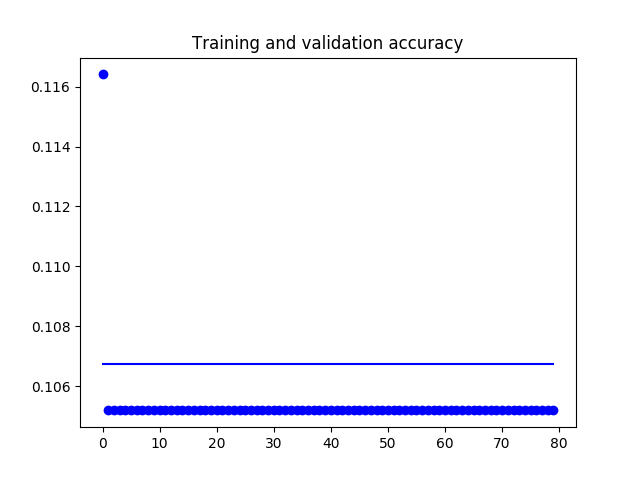

<IPython.core.display.Javascript object>


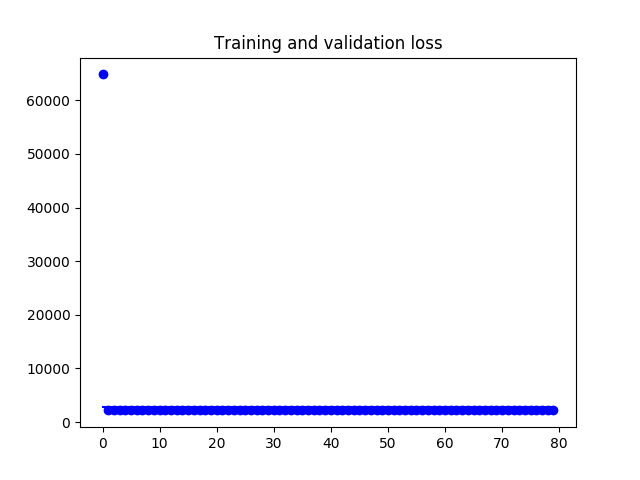

In [31]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')

plt.show()
#plt.savefig('150e_wDropout_mon.png')

In [ ]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Submission

In [ ]:
'''
Removing mismatched images, reading in images w/ corresponding attr
'''
def load_all_data(dir_path):
    df = pd.read_csv('../data/train.csv')
    
    ignore_list = read_ignore_list()
    n_train_images = 948
    
    image_list = []
    y_list = []
    
    for i in range(0, n_train_images):
        img_path = os.path.join(dir_path, str(i) + '.png')
        img = cv2.imread(img_path)
        print('Image shape: ' + str(img.shape))

        image_list.append(img)

        row = df.ix[i]

        y_row = np.zeros((5))
        y_row[0] = row['adult_males']
        y_row[1] = row['subadult_males']
        y_row[2] = row['adult_females']
        y_row[3] = row['juveniles']
        y_row[4] = row['pups']
        y_list.append(y_row)
    x_train = np.asarray(image_list)
    y_train = np.asanyarray(y_list)
    
    print('X Train: ' + str(x_train.shape))
    print('Y Train: ' + str(y_train.shape))

    return x_train, y_train

In [ ]:
'''
train model on full data
'''
def train_full():
    model = get_vgg16_model()#get_dropout_model()
    
    x_train, y_train = load_all_data('../data_512/all_data/')  #'../data_512/' train_dir
        
    datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, 
                                 rotation_range=80)
    
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=8),steps_per_epoch = len(x_train) / batch_size, epochs = epochs)
    
    model.save('./models/' + model_name + str(datetime.datetime.now())[:-7] + 'transvgg16.h5')
    
    return history

In [ ]:
history = train_full()

In [ ]:
def create_submission():
    model = load_model('./models/cnn_maxpooling_500e.h5')
    
    n_test_images = 18636
    
    pred_arr = np.zeros((n_test_images, n_classes), np.int32)
    
    for k in range(0, n_test_images):
        image_path = '../data_512/' + str(k) + '.png'
        
        img = cv2.imread(image_path)
        img = img[None, ...]
        pred = model.predict(img).astype(int)
        
        pred_arr[k,:] = pred
    
    print('Pred arr: ' + str(pred_arr.shape))
    
    pred_arr = pred_arr.clip(min=0)
    
    df_submission = pd.DataFrame()
    df_submission['test_id'] = range(0, n_test_images)
    df_submission['adult_males'] = pred_arr[:,0]
    df_submission['subadult_males'] = pred_arr[:,1]
    df_submission['adult_females'] = pred_arr[:,2]
    df_submission['juveniles'] = pred_arr[:,3]
    df_submission['pups'] = pred_arr[:,4]
    
    df_submission.to_csv('./submissions/' + 'reg_maxpooling500_submission.csv', index = False)

In [ ]:
create_submission()

In [ ]:
# sample 
from keras.applications import VGG16

def get_vgg16_model():
    batch_size= 8
    vgg16 = keras.applications.vgg16.VGG16(include_top=False, 
                                           weights='imagenet', 
                                           input_shape=(image_size,image_size,3))

    x= Conv2D(n_classes, (1, 1), activation='relu')(vgg16.output)
    x= GlobalAveragePooling2D()(x)

    model = Model(vgg16.input, x)

    print(model.summary())

    history = model.compile(loss=keras.losses.mean_squared_error,
            optimizer= keras.optimizers.Adadelta())

    return model

## Test Model

In [61]:
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.utils import np_utils

def test_model():
    pool_class = MaxPooling2D
    model = Sequential()
    model.add(ZeroPadding2D((1,1), input_shape=(image_size, image_size,3)))
    model.add(Convolution2D(32, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(32, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['accuracy'])
    print(model.summary())
    return model

## Resources

https://www.kaggle.com/c/noaa-fisheries-steller-sea-lion-population-count/

https://www.kaggle.com/radustoicescu/use-keras-to-classify-sea-lions-0-91-accuracy

https://www.kaggle.com/radustoicescu/count-the-sea-lions-in-the-first-image

https://github.com/mrgloom/Kaggle-Sea-Lions-Solution/blob/master/01-Image%20level%20regression/run_me.py

http://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/